In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import os
from IPython.display import display
import networkx as nx
import statistics
import scipy.stats as st
from sklearn.metrics import jaccard_score
from haversine import haversine

In [2]:
df_martix = pd.read_csv('./study_data/cities_gzh_aja_martix.csv')
df_citys = pd.read_csv('./study_data/sa340.csv')
df_martix.set_index('city', inplace=True)
rank = pd.read_csv('./study_data/score/城市信息+排名得分综合表.csv')
df_in_out = pd.read_csv('./study_data/all_cities_in_out_count.csv')

In [3]:
# 可视化配置
fontdict = {'weight': 600, 'size':12}

# Create a Graph

In [4]:
G = nx.from_pandas_adjacency(df_martix, create_using=nx.DiGraph)
print(G.size())
print(G)
print(G.is_directed())

# 创建目录
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path) 
        
# DIR_PATH = './data/result/重点城市分析/' + CITY_NAME + '/'
# 获取一个城市和其他城市的双向链接
def get_nodes_bi_links(CITY):
    # out
    out_nodes = []
    out_nodes.append(CITY)
    out_edges = []
    for i in list(G[CITY]):
        out_nodes.append(i)
        out_edges.append([CITY, i, G[CITY].get(i)['weight'], 'out'])

    # in
    # i --> CITY
    in_nodes = []
    in_edges = []
    for i in list(set(df_citys['name'])):
        weight = G[i].get(CITY, {'weight': 0})['weight']
        if weight > 0:
            in_nodes.append(i)
            in_edges.append([i, CITY, weight, 'in'])

    nodes = list(set(out_nodes + in_nodes))
    edges = out_edges + in_edges
    return pd.DataFrame(nodes, columns=['name']), pd.DataFrame(edges, columns=['source_city', 'target_city', 'weight', 'com_type'])


def one_city_analysis(DEFAULT_ROOT, CITY_NAME):
    DIR_PATH = './study_data/key_cities_gephi/' + DEFAULT_ROOT + ' /' + CITY_NAME + '/'
    mkdir(DIR_PATH)
    print('======done: {0}======'.format(CITY_NAME))
    do_data = get_nodes_bi_links(CITY_NAME)
    nodes = do_data[0]
    nodes['Id'] = [i for i in range(len(nodes))]
    edges = do_data[1]
    df_nodes = pd.merge(nodes, rank, on='name')[['Id', 'name', 'ARI', 'Longitude', 'Latitude', 'pro_name', 'en_name']]
    
    Source  = []
    Target = []
    # 给起点和终点设置ID
    for i, row in edges.iterrows():
        Source.append(df_nodes[df_nodes.name == row['source_city']]['Id'].values[0])
        Target.append(df_nodes[df_nodes.name == row['target_city']]['Id'].values[0])
        
    edges['Source'] = Source
    edges['Target'] = Target
    
    df_nodes.to_csv(DIR_PATH + CITY_NAME + '_nodes.csv', index=None)
    edges.to_csv(DIR_PATH + CITY_NAME + '_edges.csv', index=None)
    return df_nodes, edges

44891
DiGraph with 340 nodes and 44891 edges
True


# Given an array of Chinese city names, get in and out flow

In [5]:
def get_in_out_by_cites_list(cn_name_list, title):   
    cn_name_list = list(cn_name_list)
    print('{} 城市有：{}'.format(title, cn_name_list))
    data = []
    for i in range(len(cn_name_list)):
        cn_name = cn_name_list[i]
        en_name = rank[rank.name==cn_name]['en_name'].values[0]
        data.append([cn_name, en_name, df_in_out[df_in_out.cityname == cn_name]['in-count'].values[0], 'in'])
        data.append([cn_name, en_name, df_in_out[df_in_out.cityname == cn_name]['out-count'].values[0], 'out'])
    df = pd.DataFrame(data, columns=['name', 'City Name', 'Count', 'type'])
    display(df)
    return df

def show_bar(df, name):
    #///////////可视化////////
    sns.set_style("whitegrid")
    COLOR = '#046AC4'
    plt.figure(figsize=(11, 3))
    ax = sns.barplot(x='City Name', y='Count', hue='type',width=0.6, data=df, palette=['#EE3824', '#4A9E51'])
    plt.xlabel('City Name', fontsize=12, fontweight=600)  
    plt.ylabel('Citation', fontsize=12, fontweight=600) 
    

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 3), fontsize=9,
                    textcoords = 'offset points')
    
    plt.savefig('./study_data/figs/' + name + '_in_out.pdf', format='pdf', dpi=600, bbox_inches = 'tight')
    plt.show()

# Analysis of Top 10 cities

top10 城市有：['北京市', '上海市', '广州市', '深圳市', '杭州市', '香港特别行政区', '成都市', '重庆市', '天津市', '武汉市']


,name,City Name,Count,type
0,北京市,Beijing,36899,in
1,北京市,Beijing,836,out
2,上海市,Shanghai,22841,in
3,上海市,Shanghai,3197,out
4,广州市,Guangzhou,12751,in
5,广州市,Guangzhou,783,out
6,深圳市,Shenzhen,11783,in
7,深圳市,Shenzhen,3292,out
8,杭州市,Hangzhou,10219,in
9,杭州市,Hangzhou,1849,out


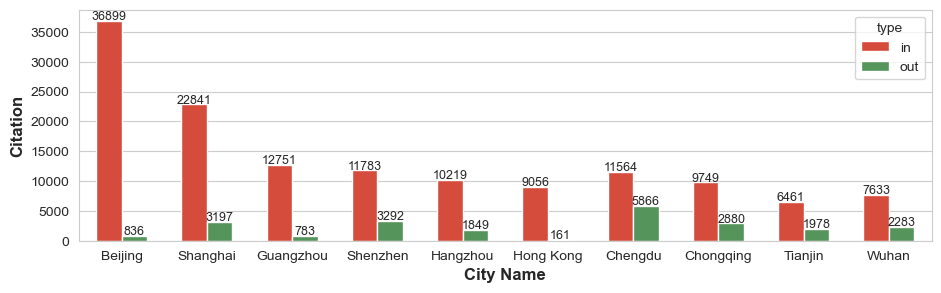

In [6]:
rank_top10 = rank.sort_values(by='ARI', ascending=False).reset_index(drop=True)[0:10]
df_top10 = get_in_out_by_cites_list(rank_top10['name'], 'top10')

show_bar(df_top10, 'top10')

In [7]:
for i in rank_top10['name']:
    print(i)
    one_city_analysis('TOP10_cities', i)

北京市
======done: 北京市======
上海市
======done: 上海市======
广州市
======done: 广州市======
深圳市
======done: 深圳市======
杭州市
======done: 杭州市======
香港特别行政区
======done: 香港特别行政区======
成都市
======done: 成都市======
重庆市
======done: 重庆市======
天津市
======done: 天津市======
武汉市
======done: 武汉市======


# Last 10 city analysis

last10 城市有：['儋州市', '博尔塔拉蒙古自治州', '石嘴山市', '锡林郭勒盟', '克拉玛依市', '三沙市', '海东市', '林芝市', '怒江傈僳族自治州', '山南市']


,name,City Name,Count,type
0,儋州市,Danzhou,168,in
1,儋州市,Danzhou,3,out
2,博尔塔拉蒙古自治州,Bortala Mongolian Autonomous Prefecture,145,in
3,博尔塔拉蒙古自治州,Bortala Mongolian Autonomous Prefecture,374,out
4,石嘴山市,Shizuishan,122,in
5,石嘴山市,Shizuishan,298,out
6,锡林郭勒盟,Xilingol League,103,in
7,锡林郭勒盟,Xilingol League,652,out
8,克拉玛依市,Karamay,93,in
9,克拉玛依市,Karamay,10,out


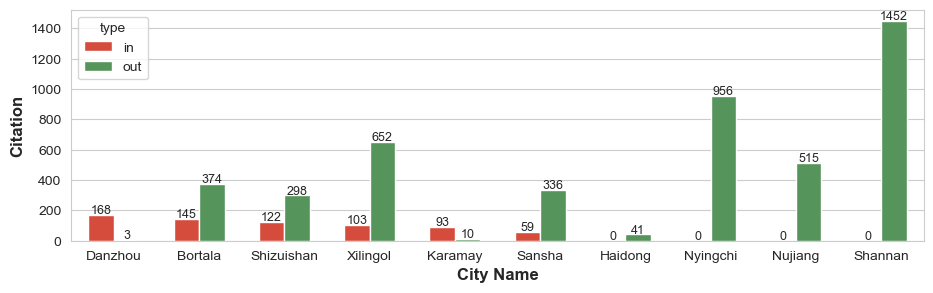

In [8]:
rank_last10 = rank.sort_values(by='ARI', ascending=False).reset_index(drop=True).tail(10)
df_last10 = get_in_out_by_cites_list(rank_last10['name'], 'last10')
df_last10['City Name'] = [i.split(' ')[0] for i in df_last10['City Name']]

show_bar(df_last10, 'last10')

In [9]:
for i in rank_last10['name']:
    print(i)
    one_city_analysis('LAST10_cities', i)

儋州市
======done: 儋州市======
博尔塔拉蒙古自治州
======done: 博尔塔拉蒙古自治州======
石嘴山市
======done: 石嘴山市======
锡林郭勒盟
======done: 锡林郭勒盟======
克拉玛依市
======done: 克拉玛依市======
三沙市
======done: 三沙市======
海东市
======done: 海东市======
林芝市
======done: 林芝市======
怒江傈僳族自治州
======done: 怒江傈僳族自治州======
山南市
======done: 山南市======


In [10]:
# https://www.datayicai.com/
# https://www.datayicai.com/report/detail/999638

# 一线城市代表（4）：上海 北京 广州 （深圳）
# 新一线城市代表（15）：成都 重庆 杭州 武汉 苏州 西安 南京 长沙 天津 郑州 东莞 青岛 昆明 宁波 （合肥）
# 二线城市（30）：佛山 沈阳 无锡 济南 厦门 福州 温州 哈尔滨 石家庄 大连 南宁 泉州 金华 贵阳 常州 长春 南昌 南通 嘉兴...（珠海）
# 三线城市（70）：兰州 海口....安庆....遵义...宁德....（三亚）...淄博
# 四线城市（90）：韶关.....（宝鸡）...茂名
# 五线城市（128）：（鹤岗）、丽江

# level_cites = ['上海市', '杭州市', '珠海市', '安庆市', '亳州市', '鹤岗市']
    

# Intensity of influence

In [11]:
# 联系强度: 改进重力模型
# 城市A的辐射系数
def get_gravity(city):
    
    data = []
    cityA = rank[rank.name==city]
    cityA_CII = cityA['ARI'].values[0]

    for i in list(df_citys['name']):
        if i != city:
            cityB = rank[rank.name==i]
            cityB_CII = cityB['ARI'].values[0]
            cityB_2_A = df_martix.loc[i, city]
            # cityA_2_B = df_martix.loc[city, i] + 1/len(df_citys)

            distance = haversine((cityA['Latitude'].values[0], cityA['Longitude'].values[0]), 
                                 (cityB['Latitude'].values[0], cityB['Longitude'].values[0]))

            result = cityB_2_A * cityA_CII / (distance) 
            data.append([city, i, result])
        
    df = pd.DataFrame(data, columns=['target_city', 'source_city', 'intensity'])
    
    
    df = df.sort_values(by='intensity', ascending=False).reset_index(drop=True)
    return df

## visualization

In [23]:
pro_en = pd.read_csv('./study_data/省英文名称.csv')
def show_graph(city, is_CN=False): 
    temp = get_gravity(city)[0:20]
    print(temp)
   
    nodes_cn_name = list(set(list(temp['target_city']) + list(temp['source_city'])))
    nodes = pd.DataFrame(nodes_cn_name, columns=['name'])
    nodes = pd.merge(nodes, rank, on='name')[['name', 'ARI', 'Longitude', 'Latitude', 'pro_name', 'en_name']]

    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    G = nx.from_pandas_edgelist(temp, 'source_city', 'target_city', edge_attr=['intensity'])
    edge_weights = [G[u][v]['intensity']/25 for u, v in G.edges()]
    
    edge_labels = {(u, v): "{:.2f}".format(d['intensity']) for u, v, d in G.edges(data=True)}

    pos = nx.kamada_kawai_layout(G)
    node_sizes = []
    labels = {}
    
    for node in G.nodes():
        node_sizes.append(round(list(nodes[nodes.name==node]['ARI'])[0], 2) * 20)
        
        # node 标签
        pro_cn_name = list(nodes[nodes.name==node]['pro_name'])[0]
        pro_en_name = list(pro_en[pro_en.pro_name==pro_cn_name]['en_short'])[0]
        lb = list(nodes[nodes.name==node]['en_name'])[0].replace('Prefecture', '').replace('Autonomous', '') + '(' + pro_en_name + ')'
        
        if is_CN:
            labels[node] = node
        else:
            labels[node] = lb


    plt.figure(figsize=(7, 6)) 
    nx.draw(G, pos, with_labels=True, 
            labels=labels,
            node_color='#5CD38E', 
            node_size=node_sizes, font_size=12, font_color='black',
            edge_color = '#EE3824',
            width=edge_weights)

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', bbox={'alpha': 0})
    prefix = './study_data/figs/intensity/city_intensity_en_'
    if is_CN: 
        prefix = './study_data/figs/intensity/city_intensity_cn_'
    
    plt.savefig(prefix + city + '.pdf', format='pdf', dpi=600, bbox_inches = 'tight')
    plt.show()

In [24]:
get_gravity('珠海市')[0:40]

,target_city,source_city,intensity
0,珠海市,澳门特别行政区,669.377364
1,珠海市,中山市,171.826016
2,珠海市,江门市,117.460383
3,珠海市,深圳市,70.877193
4,珠海市,佛山市,42.987257
5,珠海市,阳江市,26.587872
6,珠海市,韶关市,23.806757
7,珠海市,肇庆市,20.887961
8,珠海市,清远市,19.002841
9,珠海市,揭阳市,18.188022


   target_city source_city   intensity
0          上海市         苏州市  373.977627
1          上海市         嘉兴市  339.226348
2          上海市         南通市  299.682575
3          上海市         无锡市  186.053452
4          上海市         常州市  147.802473
5          上海市         湖州市   83.455032
6          上海市         宁波市   71.167449
7          上海市         泰州市   68.944673
8          上海市         杭州市   65.360609
9          上海市         盐城市   58.592566
10         上海市         台州市   54.661865
11         上海市         舟山市   54.058373
12         上海市         丽水市   44.632697
13         上海市         南京市   44.584148
14         上海市         绍兴市   44.376852
15         上海市         镇江市   42.318208
16         上海市         合肥市   40.561877
17         上海市        马鞍山市   40.113914
18         上海市         黄山市   38.404078
19         上海市         淮安市   38.187266


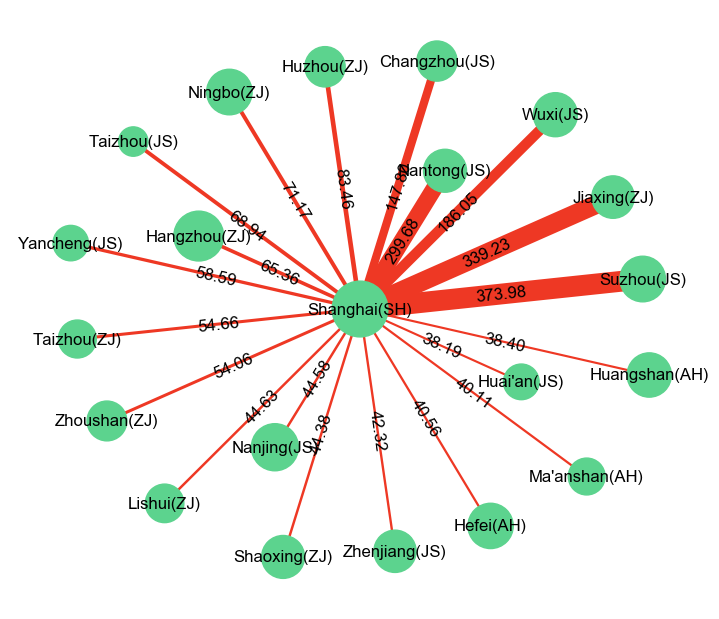

   target_city source_city   intensity
0          上海市         苏州市  373.977627
1          上海市         嘉兴市  339.226348
2          上海市         南通市  299.682575
3          上海市         无锡市  186.053452
4          上海市         常州市  147.802473
5          上海市         湖州市   83.455032
6          上海市         宁波市   71.167449
7          上海市         泰州市   68.944673
8          上海市         杭州市   65.360609
9          上海市         盐城市   58.592566
10         上海市         台州市   54.661865
11         上海市         舟山市   54.058373
12         上海市         丽水市   44.632697
13         上海市         南京市   44.584148
14         上海市         绍兴市   44.376852
15         上海市         镇江市   42.318208
16         上海市         合肥市   40.561877
17         上海市        马鞍山市   40.113914
18         上海市         黄山市   38.404078
19         上海市         淮安市   38.187266


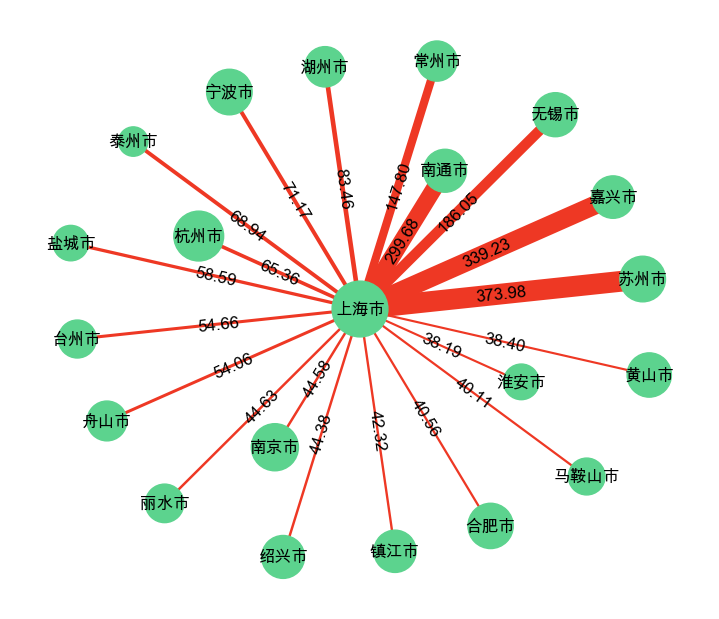

In [25]:
show_graph('上海市')
show_graph('上海市', True)

   target_city source_city   intensity
0          杭州市         绍兴市  418.707669
1          杭州市         嘉兴市  265.587474
2          杭州市         湖州市  251.984288
3          杭州市         金华市  200.323564
4          杭州市         宁波市  124.045694
5          杭州市         丽水市  121.814368
6          杭州市         台州市  117.106268
7          杭州市         上海市   74.644334
8          杭州市         衢州市   73.077028
9          杭州市         温州市   68.422429
10         杭州市         舟山市   45.064768
11         杭州市         黄山市   42.036268
12         杭州市         苏州市   35.194579
13         杭州市         无锡市   32.460303
14         杭州市         常州市   31.167280
15         杭州市         南通市   21.806108
16         杭州市         宣城市   16.200053
17         杭州市         南京市   15.928653
18         杭州市        景德镇市   13.018927
19         杭州市         九江市   12.863012


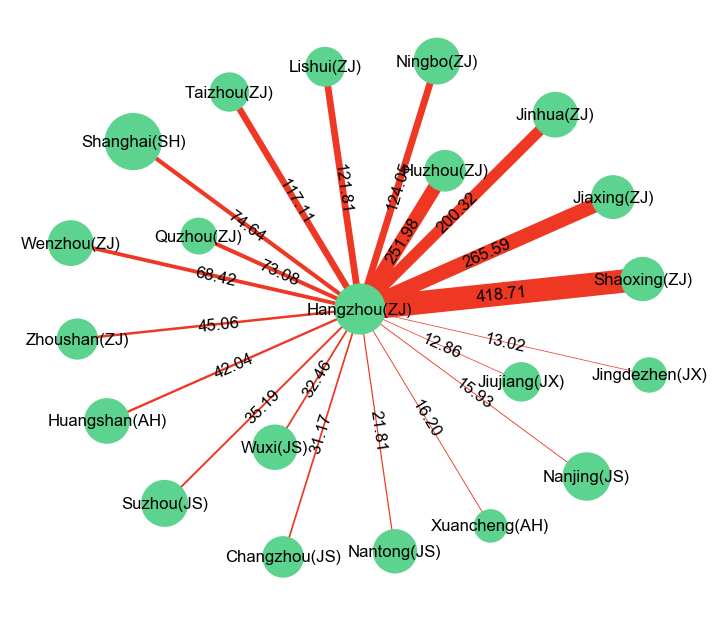

   target_city source_city   intensity
0          杭州市         绍兴市  418.707669
1          杭州市         嘉兴市  265.587474
2          杭州市         湖州市  251.984288
3          杭州市         金华市  200.323564
4          杭州市         宁波市  124.045694
5          杭州市         丽水市  121.814368
6          杭州市         台州市  117.106268
7          杭州市         上海市   74.644334
8          杭州市         衢州市   73.077028
9          杭州市         温州市   68.422429
10         杭州市         舟山市   45.064768
11         杭州市         黄山市   42.036268
12         杭州市         苏州市   35.194579
13         杭州市         无锡市   32.460303
14         杭州市         常州市   31.167280
15         杭州市         南通市   21.806108
16         杭州市         宣城市   16.200053
17         杭州市         南京市   15.928653
18         杭州市        景德镇市   13.018927
19         杭州市         九江市   12.863012


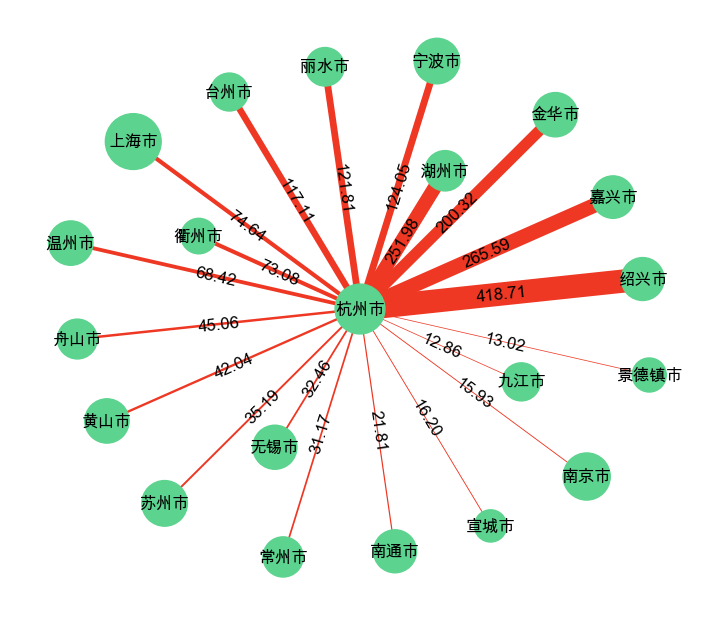

In [26]:
show_graph('杭州市')
show_graph('杭州市', True)

   target_city source_city   intensity
0          珠海市     澳门特别行政区  669.377364
1          珠海市         中山市  171.826016
2          珠海市         江门市  117.460383
3          珠海市         深圳市   70.877193
4          珠海市         佛山市   42.987257
5          珠海市         阳江市   26.587872
6          珠海市         韶关市   23.806757
7          珠海市         肇庆市   20.887961
8          珠海市         清远市   19.002841
9          珠海市         揭阳市   18.188022
10         珠海市         广州市   14.836456
11         珠海市         惠州市   14.697274
12         珠海市         汕头市   13.171301
13         珠海市         茂名市   13.069501
14         珠海市         云浮市   12.965682
15         珠海市         东莞市   11.266213
16         珠海市         湛江市    9.282777
17         珠海市     香港特别行政区    7.851391
18         珠海市         潮州市    7.210611
19         珠海市         汕尾市    6.619719


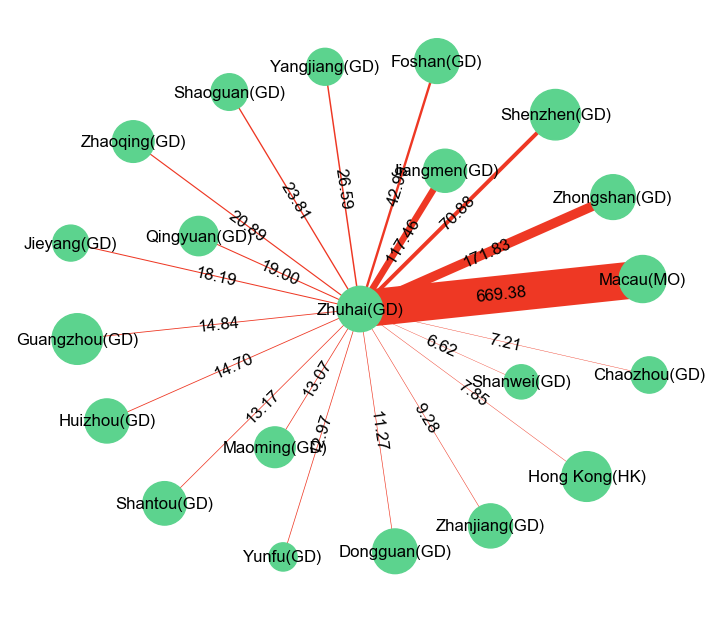

   target_city source_city   intensity
0          珠海市     澳门特别行政区  669.377364
1          珠海市         中山市  171.826016
2          珠海市         江门市  117.460383
3          珠海市         深圳市   70.877193
4          珠海市         佛山市   42.987257
5          珠海市         阳江市   26.587872
6          珠海市         韶关市   23.806757
7          珠海市         肇庆市   20.887961
8          珠海市         清远市   19.002841
9          珠海市         揭阳市   18.188022
10         珠海市         广州市   14.836456
11         珠海市         惠州市   14.697274
12         珠海市         汕头市   13.171301
13         珠海市         茂名市   13.069501
14         珠海市         云浮市   12.965682
15         珠海市         东莞市   11.266213
16         珠海市         湛江市    9.282777
17         珠海市     香港特别行政区    7.851391
18         珠海市         潮州市    7.210611
19         珠海市         汕尾市    6.619719


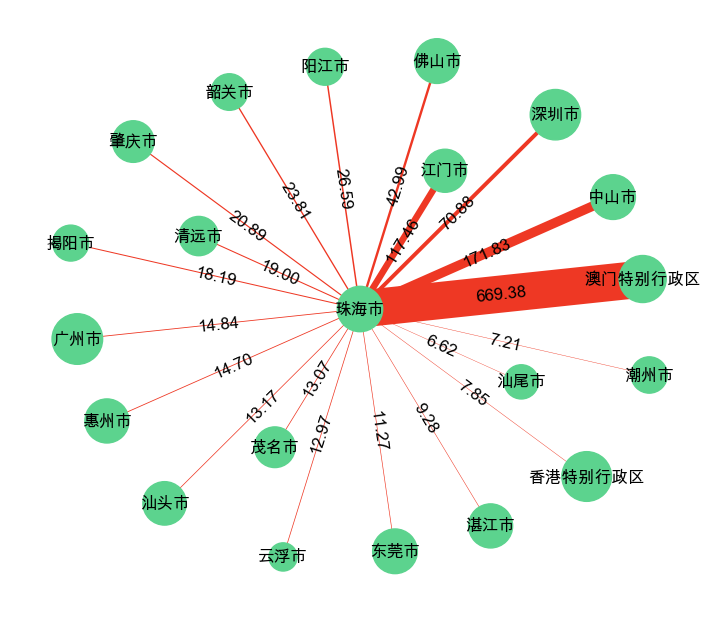

In [27]:
show_graph('珠海市')
show_graph('珠海市', True)

   target_city source_city  intensity
0          安庆市         铜陵市  34.748709
1          安庆市         池州市  33.422147
2          安庆市         合肥市  27.698041
3          安庆市         芜湖市  15.074303
4          安庆市        马鞍山市  10.228041
5          安庆市         宿州市  10.127499
6          安庆市         黄山市   8.930216
7          安庆市         淮南市   8.708098
8          安庆市         宣城市   8.352734
9          安庆市         蚌埠市   8.054408
10         安庆市         六安市   8.051445
11         安庆市         阜阳市   7.810591
12         安庆市         亳州市   5.511176
13         安庆市         滁州市   4.008932
14         安庆市         南京市   3.849113
15         安庆市         淮北市   2.145425
16         安庆市         上海市   1.936817
17         安庆市         九江市   1.055562
18         安庆市         武汉市   0.869689
19         安庆市         无锡市   0.725402


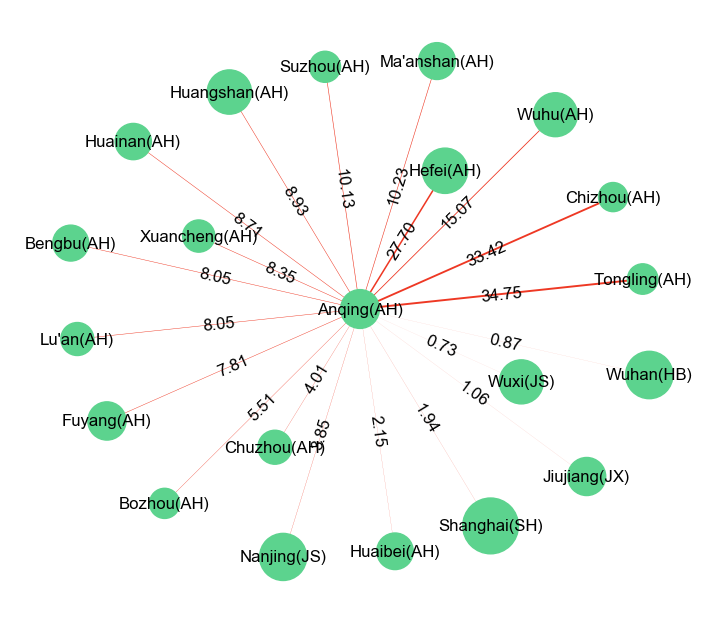

   target_city source_city  intensity
0          安庆市         铜陵市  34.748709
1          安庆市         池州市  33.422147
2          安庆市         合肥市  27.698041
3          安庆市         芜湖市  15.074303
4          安庆市        马鞍山市  10.228041
5          安庆市         宿州市  10.127499
6          安庆市         黄山市   8.930216
7          安庆市         淮南市   8.708098
8          安庆市         宣城市   8.352734
9          安庆市         蚌埠市   8.054408
10         安庆市         六安市   8.051445
11         安庆市         阜阳市   7.810591
12         安庆市         亳州市   5.511176
13         安庆市         滁州市   4.008932
14         安庆市         南京市   3.849113
15         安庆市         淮北市   2.145425
16         安庆市         上海市   1.936817
17         安庆市         九江市   1.055562
18         安庆市         武汉市   0.869689
19         安庆市         无锡市   0.725402


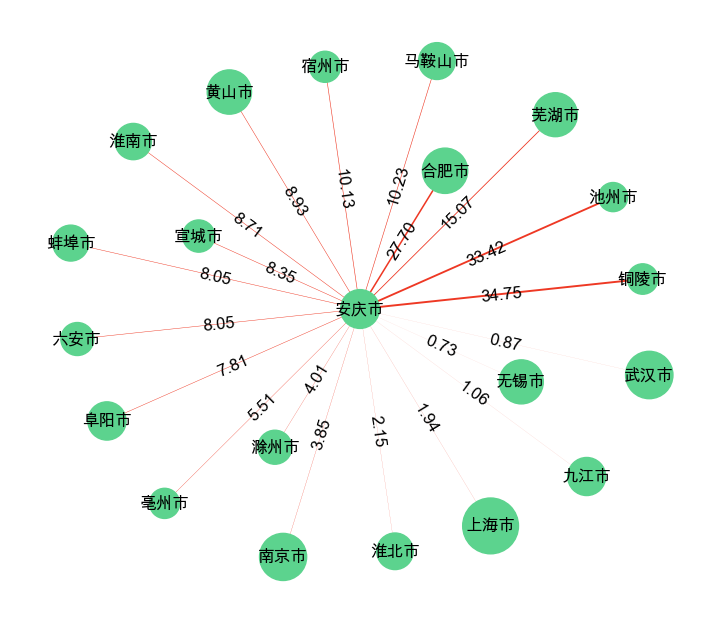

In [28]:
show_graph('安庆市')
show_graph('安庆市', True)

   target_city source_city  intensity
0         景德镇市         九江市  19.213490
1         景德镇市         鹰潭市  15.518268
2         景德镇市         南昌市  15.355545
3         景德镇市         上饶市   8.715918
4         景德镇市         抚州市   7.692323
5         景德镇市         宜春市   4.672199
6         景德镇市         黄山市   3.947242
7         景德镇市         新余市   3.943927
8         景德镇市         吉安市   2.213962
9         景德镇市         萍乡市   2.199396
10        景德镇市         赣州市   1.086844
11        景德镇市         杭州市   0.965256
12        景德镇市         丽水市   0.534259
13        景德镇市         合肥市   0.530806
14        景德镇市         南京市   0.434507
15        景德镇市         上海市   0.387211
16        景德镇市         衢州市   0.361886
17        景德镇市         宿州市   0.308783
18        景德镇市         蚌埠市   0.296531
19        景德镇市         长沙市   0.279669


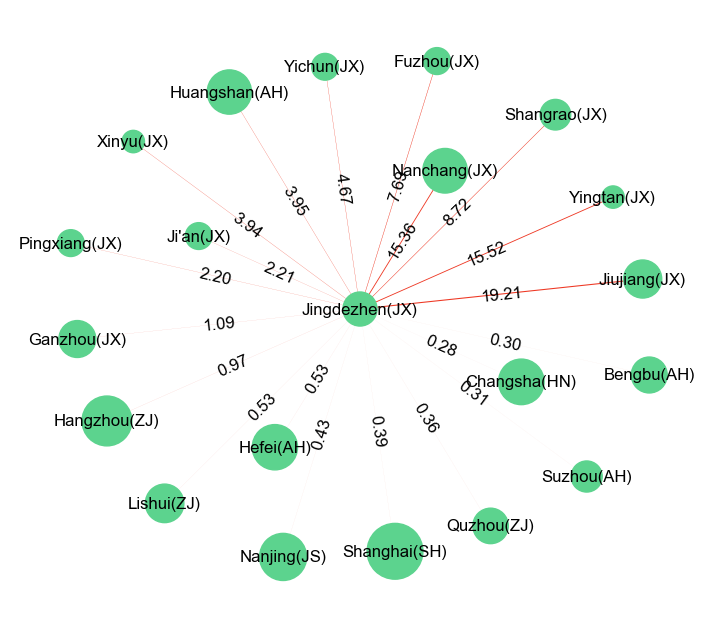

   target_city source_city  intensity
0         景德镇市         九江市  19.213490
1         景德镇市         鹰潭市  15.518268
2         景德镇市         南昌市  15.355545
3         景德镇市         上饶市   8.715918
4         景德镇市         抚州市   7.692323
5         景德镇市         宜春市   4.672199
6         景德镇市         黄山市   3.947242
7         景德镇市         新余市   3.943927
8         景德镇市         吉安市   2.213962
9         景德镇市         萍乡市   2.199396
10        景德镇市         赣州市   1.086844
11        景德镇市         杭州市   0.965256
12        景德镇市         丽水市   0.534259
13        景德镇市         合肥市   0.530806
14        景德镇市         南京市   0.434507
15        景德镇市         上海市   0.387211
16        景德镇市         衢州市   0.361886
17        景德镇市         宿州市   0.308783
18        景德镇市         蚌埠市   0.296531
19        景德镇市         长沙市   0.279669


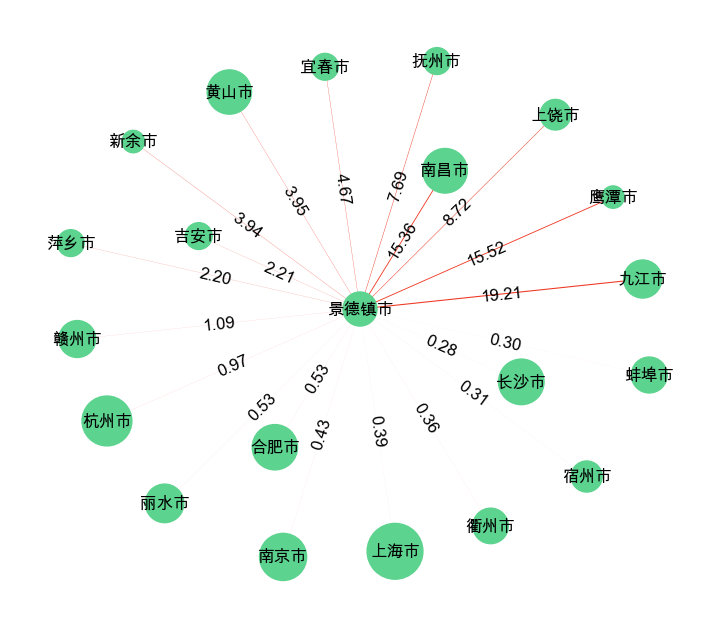

In [29]:
show_graph('景德镇市')
show_graph('景德镇市', True)

   target_city source_city  intensity
0          鹤岗市        双鸭山市  18.039882
1          鹤岗市        佳木斯市   6.330796
2          鹤岗市         伊春市   3.538566
3          鹤岗市       齐齐哈尔市   2.365631
4          鹤岗市        哈尔滨市   2.274499
5          鹤岗市        牡丹江市   0.720567
6          鹤岗市         鸡西市   0.171198
7          鹤岗市        七台河市   0.072781
8          鹤岗市         黑河市   0.070309
9          鹤岗市      大兴安岭地区   0.047299
10         鹤岗市         汕头市   0.036507
11         鹤岗市    延边朝鲜族自治州   0.026846
12         鹤岗市         梧州市   0.025499
13         鹤岗市         白山市   0.019812
14         鹤岗市         丹东市   0.014133
15         鹤岗市         抚州市   0.010813
16         鹤岗市         唐山市   0.010300
17         鹤岗市       呼和浩特市   0.008138
18         鹤岗市         吕梁市   0.007014
19         鹤岗市         九江市   0.005761


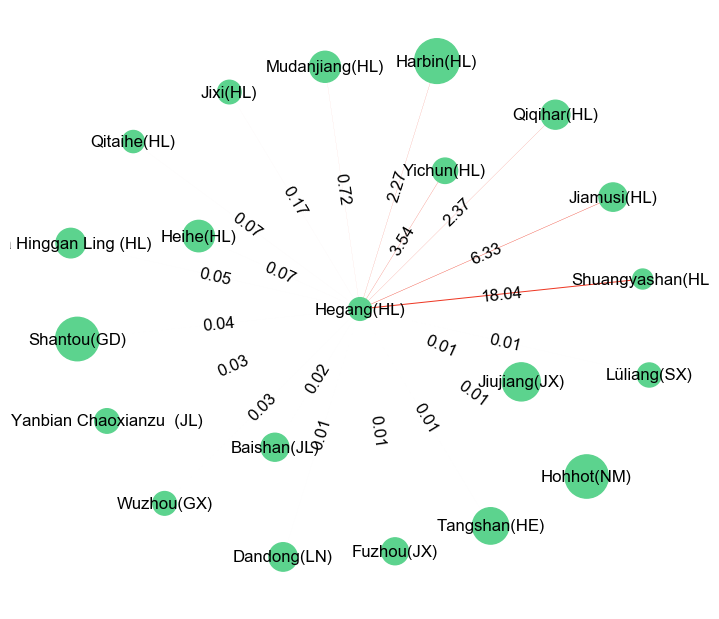

   target_city source_city  intensity
0          鹤岗市        双鸭山市  18.039882
1          鹤岗市        佳木斯市   6.330796
2          鹤岗市         伊春市   3.538566
3          鹤岗市       齐齐哈尔市   2.365631
4          鹤岗市        哈尔滨市   2.274499
5          鹤岗市        牡丹江市   0.720567
6          鹤岗市         鸡西市   0.171198
7          鹤岗市        七台河市   0.072781
8          鹤岗市         黑河市   0.070309
9          鹤岗市      大兴安岭地区   0.047299
10         鹤岗市         汕头市   0.036507
11         鹤岗市    延边朝鲜族自治州   0.026846
12         鹤岗市         梧州市   0.025499
13         鹤岗市         白山市   0.019812
14         鹤岗市         丹东市   0.014133
15         鹤岗市         抚州市   0.010813
16         鹤岗市         唐山市   0.010300
17         鹤岗市       呼和浩特市   0.008138
18         鹤岗市         吕梁市   0.007014
19         鹤岗市         九江市   0.005761


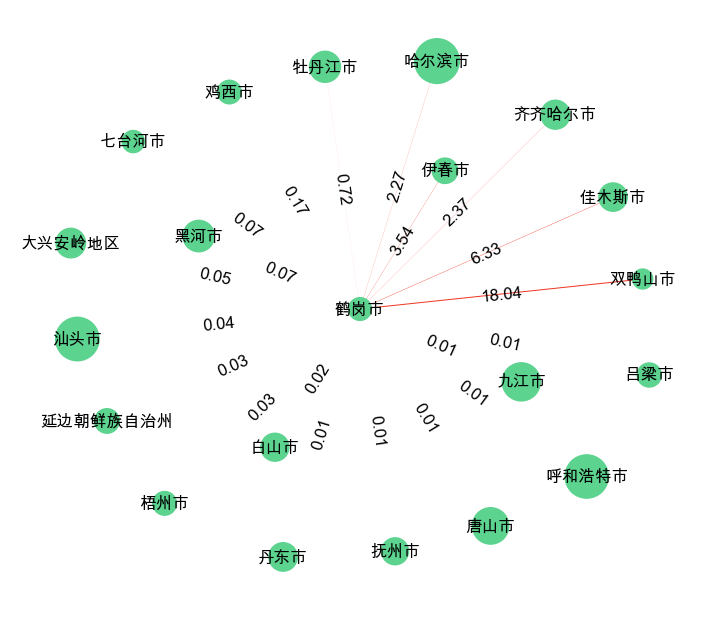

In [30]:
show_graph('鹤岗市')
show_graph('鹤岗市', True)

   target_city source_city    intensity
0      香港特别行政区         深圳市  1209.993627
1      香港特别行政区         珠海市   209.329023
2      香港特别行政区     澳门特别行政区   180.000564
3      香港特别行政区         江门市   122.096183
4      香港特别行政区         中山市    97.110481
5      香港特别行政区         佛山市    71.170320
6      香港特别行政区         惠州市    59.907371
7      香港特别行政区         东莞市    59.747150
8      香港特别行政区         汕头市    59.314287
9      香港特别行政区         肇庆市    27.919117
10     香港特别行政区         广州市    22.170381
11     香港特别行政区         揭阳市    20.194247
12     香港特别行政区         韶关市    18.909835
13     香港特别行政区         潮州市    18.499264
14     香港特别行政区         汕尾市    17.406282
15     香港特别行政区         河源市    16.760915
16     香港特别行政区         云浮市    13.663693
17     香港特别行政区         阳江市    13.344144
18     香港特别行政区         三明市    10.411398
19     香港特别行政区         茂名市     9.369184


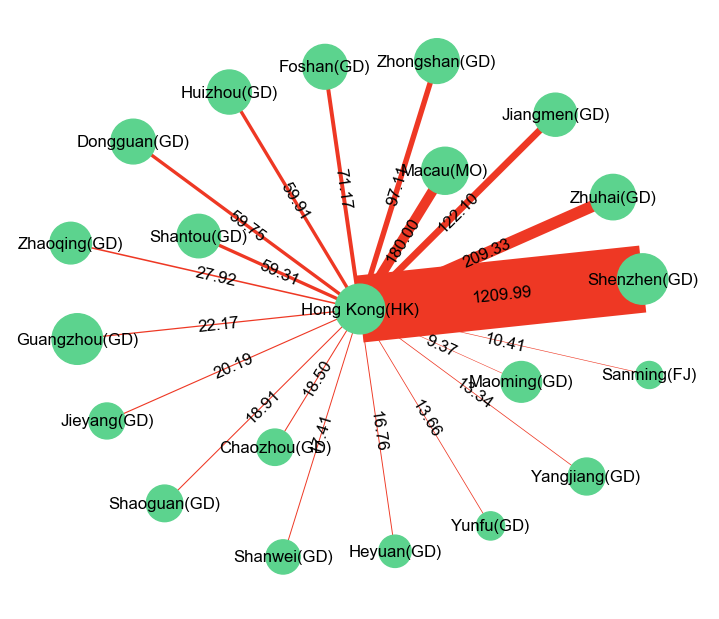

   target_city source_city    intensity
0      香港特别行政区         深圳市  1209.993627
1      香港特别行政区         珠海市   209.329023
2      香港特别行政区     澳门特别行政区   180.000564
3      香港特别行政区         江门市   122.096183
4      香港特别行政区         中山市    97.110481
5      香港特别行政区         佛山市    71.170320
6      香港特别行政区         惠州市    59.907371
7      香港特别行政区         东莞市    59.747150
8      香港特别行政区         汕头市    59.314287
9      香港特别行政区         肇庆市    27.919117
10     香港特别行政区         广州市    22.170381
11     香港特别行政区         揭阳市    20.194247
12     香港特别行政区         韶关市    18.909835
13     香港特别行政区         潮州市    18.499264
14     香港特别行政区         汕尾市    17.406282
15     香港特别行政区         河源市    16.760915
16     香港特别行政区         云浮市    13.663693
17     香港特别行政区         阳江市    13.344144
18     香港特别行政区         三明市    10.411398
19     香港特别行政区         茂名市     9.369184


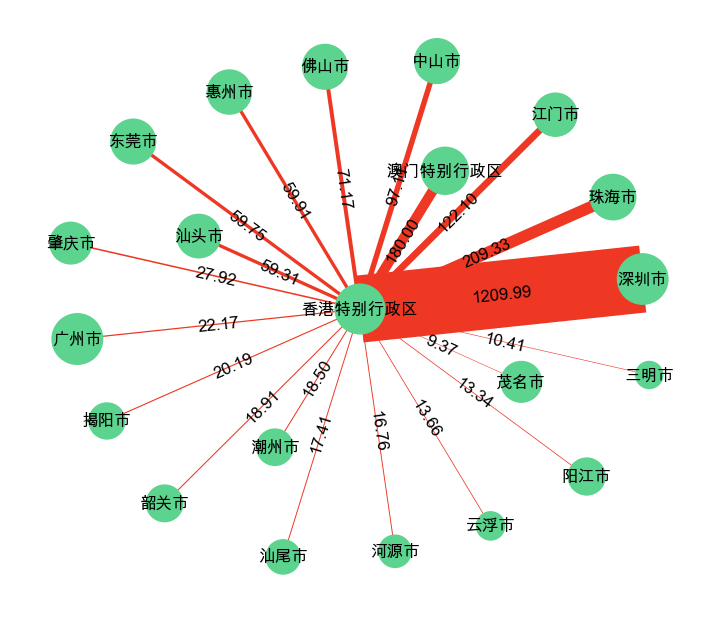

In [31]:
show_graph('香港特别行政区')
show_graph('香港特别行政区', True)

   target_city source_city    intensity
0          广州市         佛山市  1639.916464
1          广州市         江门市   389.180048
2          广州市         清远市   315.521067
3          广州市         肇庆市   228.184398
4          广州市         中山市   196.838242
5          广州市         东莞市   190.026262
6          广州市         深圳市   177.543015
7          广州市         韶关市   152.256223
8          广州市         云浮市   124.712809
9          广州市         珠海市   119.897575
10         广州市         惠州市   103.667558
11         广州市         汕头市    82.807789
12         广州市         茂名市    67.567247
13         广州市         揭阳市    61.003105
14         广州市         阳江市    60.051859
15         广州市         河源市    52.124633
16         广州市         汕尾市    51.679333
17         广州市         潮州市    47.894879
18         广州市         湛江市    38.292153
19         广州市         梅州市    34.189795


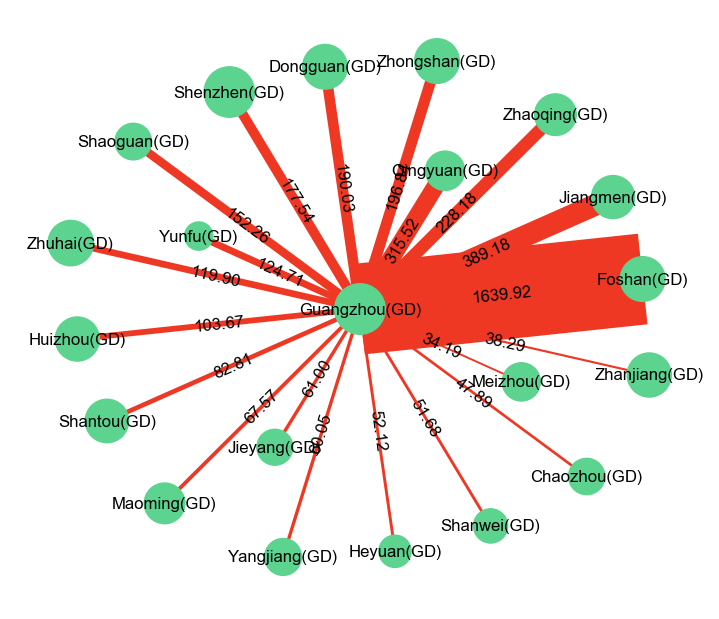

   target_city source_city    intensity
0          广州市         佛山市  1639.916464
1          广州市         江门市   389.180048
2          广州市         清远市   315.521067
3          广州市         肇庆市   228.184398
4          广州市         中山市   196.838242
5          广州市         东莞市   190.026262
6          广州市         深圳市   177.543015
7          广州市         韶关市   152.256223
8          广州市         云浮市   124.712809
9          广州市         珠海市   119.897575
10         广州市         惠州市   103.667558
11         广州市         汕头市    82.807789
12         广州市         茂名市    67.567247
13         广州市         揭阳市    61.003105
14         广州市         阳江市    60.051859
15         广州市         河源市    52.124633
16         广州市         汕尾市    51.679333
17         广州市         潮州市    47.894879
18         广州市         湛江市    38.292153
19         广州市         梅州市    34.189795


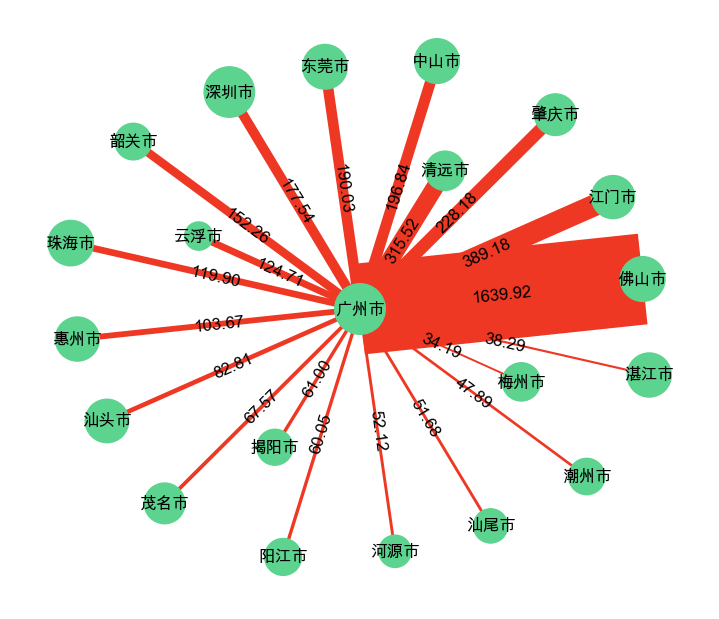

In [32]:
show_graph('广州市')
show_graph('广州市', True)

   target_city source_city    intensity
0          北京市         廊坊市  1107.507902
1          北京市         天津市   484.496023
2          北京市         沧州市   375.876760
3          北京市         保定市   340.780794
4          北京市         承德市   309.322584
5          北京市        秦皇岛市   127.284271
6          北京市        张家口市    92.628196
7          北京市         唐山市    84.122441
8          北京市        石家庄市    73.140244
9          北京市         大同市    61.183427
10         北京市         邯郸市    59.098452
11         北京市       乌兰察布市    48.930766
12         北京市         德州市    47.371524
13         北京市       齐齐哈尔市    46.753614
14         北京市         包头市    46.268073
15         北京市         衡水市    40.551132
16         北京市        哈尔滨市    36.562080
17         北京市         焦作市    36.197684
18         北京市         晋中市    35.389994
19         北京市         朝阳市    34.680857


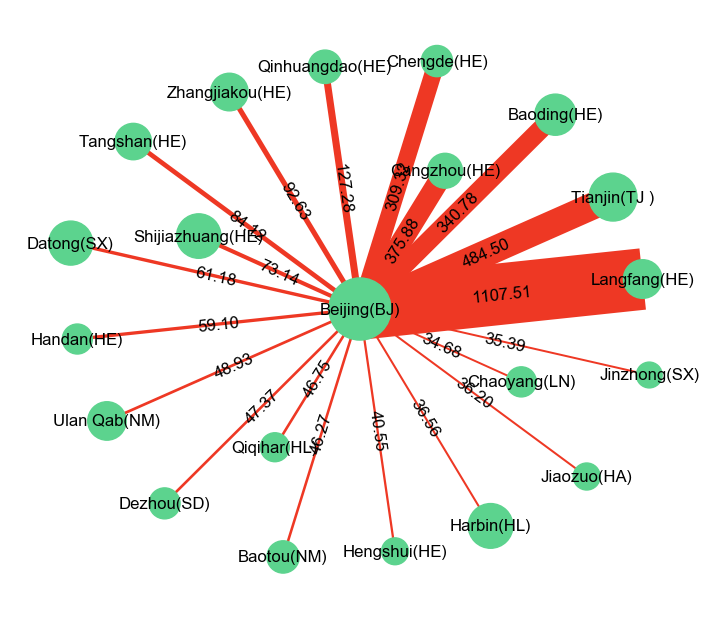

   target_city source_city    intensity
0          北京市         廊坊市  1107.507902
1          北京市         天津市   484.496023
2          北京市         沧州市   375.876760
3          北京市         保定市   340.780794
4          北京市         承德市   309.322584
5          北京市        秦皇岛市   127.284271
6          北京市        张家口市    92.628196
7          北京市         唐山市    84.122441
8          北京市        石家庄市    73.140244
9          北京市         大同市    61.183427
10         北京市         邯郸市    59.098452
11         北京市       乌兰察布市    48.930766
12         北京市         德州市    47.371524
13         北京市       齐齐哈尔市    46.753614
14         北京市         包头市    46.268073
15         北京市         衡水市    40.551132
16         北京市        哈尔滨市    36.562080
17         北京市         焦作市    36.197684
18         北京市         晋中市    35.389994
19         北京市         朝阳市    34.680857


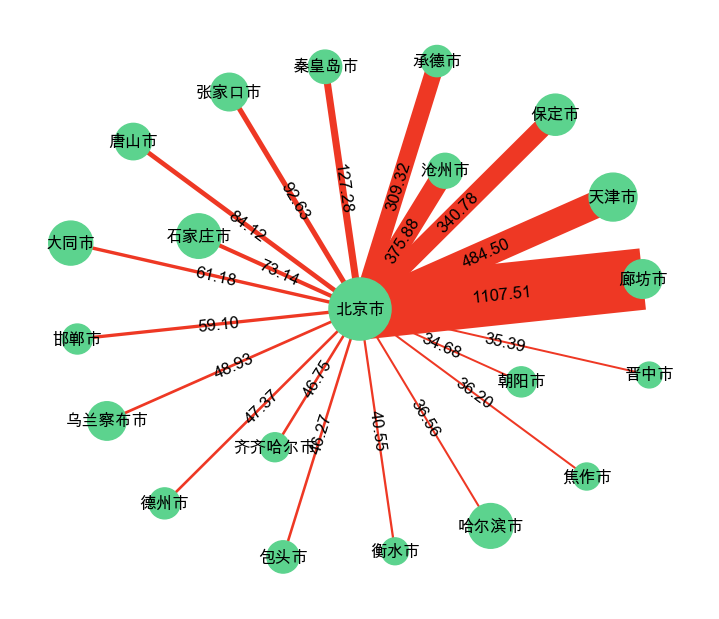

In [35]:
show_graph('北京市')
show_graph('北京市', True)